In [1]:
!git clone https://github.com/hpcaitech/ColossalAI.git

Cloning into 'ColossalAI'...
remote: Enumerating objects: 41488, done.
remote: Counting objects: 100% (1916/1916), done.
remote: Compressing objects: 100% (1293/1293), done.
remote: Total 41488 (delta 1039), reused 1244 (delta 611), pack-reused 39572
Receiving objects: 100% (41488/41488), 30.14 MiB | 27.83 MiB/s, done.
Resolving deltas: 100% (27970/27970), done.


In [2]:
cd ColossalAI/examples/images/vit

/kaggle/working/ColossalAI/examples/images/vit


In [3]:
my_benchmark = '''
set -xe
pip install -r requirements.txt

export BS=8
export MEMCAP=0
export GPUNUM=2

for BS in 8 16 32 64 128 256
do
for PLUGIN in "torch_ddp" "torch_ddp_fp16" "low_level_zero" "gemini"
do
for iter in {1..3} 
do

MODEL_PATH="google/vit-base-patch16-224"
colossalai run \
  --nproc_per_node ${GPUNUM} \
  --master_port 29505 \
  vit_benchmark.py \
  --model_name_or_path ${MODEL_PATH} \
  --mem_cap ${MEMCAP} \
  --plugin ${PLUGIN} \
  --batch_size ${BS}

done
done
done
'''

file_path = '/kaggle/working/ColossalAI/examples/images/vit/my_benchmark.sh'

with open(file_path, 'w') as file:
    file.write(my_benchmark)

In [4]:
!bash my_benchmark.sh > log.txt 2> errors.txt

In [5]:
import pandas as pd

batchs = []
plugins = []
throughputs = []
memory_usages = []

with open('log.txt', 'r') as file:
    lines = file.readlines()
    for i in range(len(lines)):
        if 'batch size per gpu' in lines[i]:
            line = lines[i].strip() + lines[i+1].strip() + lines[i+2].strip()
            batch, plugin, throughput, memory = line.split(',')
            batch = int(batch.split()[-1][7:][:-4])
            plugin = plugin.split()[-1]
            throughput = float(throughput.split()[-1][7:][:-4])
            memory_unit = memory.split()[-1][:-1]
            memory_usage = float(memory.split()[-2][7:][:-4])
            if memory_unit == 'MB':
                memory_usage /= 1024
            batchs.append(batch)
            plugins.append(plugin)
            throughputs.append(throughput)
            memory_usages.append(memory_usage)

test_log = pd.DataFrame({'batch': batchs, 'plugin': plugins, 'throughput':throughputs, 'memory_usage_per_gpu(GB)':memory_usages})
test_log.to_csv('benchmark.csv')
test_log

,batch,plugin,throughput,memory_usage_per_gpu(GB)
0,8,torch_ddp,40.6788,1.74
1,8,torch_ddp,43.5375,1.74
2,8,torch_ddp,42.8135,1.74
3,8,torch_ddp_fp16,88.4395,1.73
4,8,torch_ddp_fp16,89.7040,1.73
...,...,...,...,...
67,256,low_level_zero,165.7287,3.53
68,256,low_level_zero,166.2423,3.53
69,256,gemini,167.3044,2.98
70,256,gemini,167.2551,2.98


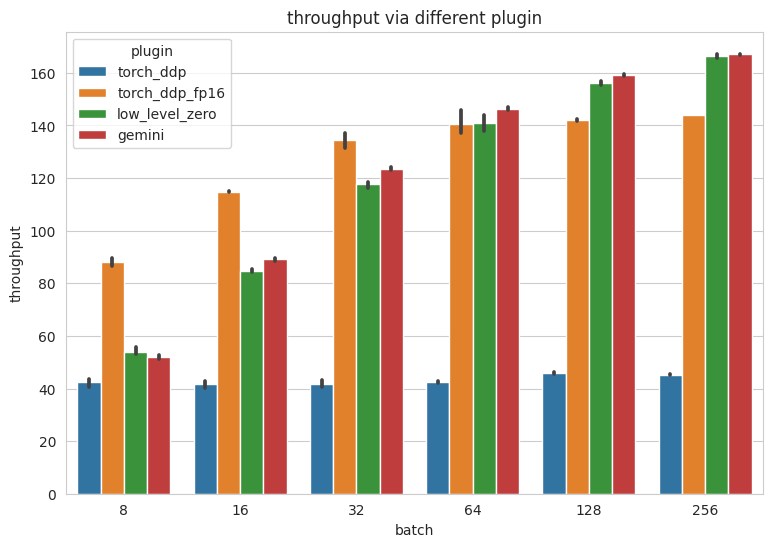

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
plt.figure(figsize=(9, 6))
sns.barplot(x='batch', y='throughput', hue='plugin', data=test_log)
plt.title('throughput via different plugin')
plt.savefig('throughput.png')

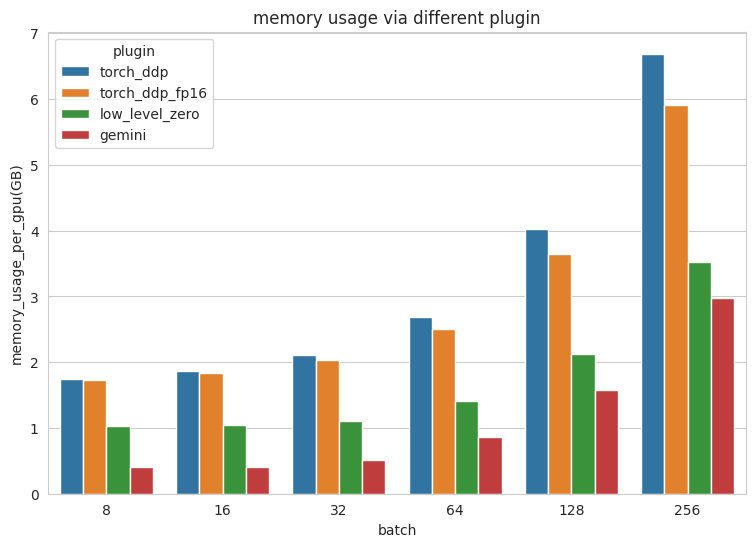

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(9, 6))
sns.barplot(x='batch', y='memory_usage_per_gpu(GB)', hue='plugin', data=test_log)
plt.title('memory usage via different plugin')
plt.savefig('memory.png')